In [125]:
# read the data and turn it into a dataframe
#imports"
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
import pandas as pd
import os

# Create a Path object for the current directory
current_directory = Path.cwd()
print("Current Directory:", current_directory.resolve())

# Creating a Path object for an example file that does not yet exist
example_file_path = current_directory / "database.csv"

# Reading the contents of the file to test if we have well acess to our data
if example_file_path.exists():
    with example_file_path.open("r") as file:
        first_line = file.readline()
        print(first_line)
else:
    print("The file does not exist.")

dataFrame= pd.read_csv("database.csv")

Current Directory: C:\Users\33783\Documents\EPFL\Etudes\BA4\Amazing-Project
Reactant 1;Reactant 2;Product 1;Product 2;Product 3;yield;reaction_smarts



In [126]:
# Remove atome mapping numbers from smiles
import re

def remove_atom_mapping(smiles):
    """
    Remove atom mapping numbers from a SMILES-like notation.
    Args:
    - smiles (str): The SMILES-like notation with atom mapping numbers.
    Returns:
    - smiles_without_mapping (str): The SMILES notation without atom mapping numbers.
    """
    # Define a regular expression pattern to match atom mapping numbers
    pattern = r':\d+'
    smiles_without_mapping = re.sub(pattern, '', smiles)
    return smiles_without_mapping

In [127]:
# give smiles

import re

def Smiles(smiles):
    """
    Remove atom mapping numbers, brackets, 'H' characters, and empty parentheses from a SMILES-like notation.
    Args:
    - smiles (str): The SMILES-like notation with atom mapping numbers, brackets, 'H' characters, and empty parentheses.
    Returns:
    - smiles_cleaned (str): The cleaned SMILES notation.
    """
    # Define a regular expression pattern to match atom mapping numbers, brackets, 'H' characters, and empty parentheses
    pattern = r'[:\[\]\ H@\/]'
    # Use re.sub() to remove the specified characters
    smiles_cleaned = re.sub(pattern, '', smiles)
    # Remove empty parentheses only
    smiles_cleaned = re.sub(r'\(\)', '', smiles_cleaned)
    return smiles_cleaned

def remove_back_slash(smiles):
    """
    Remove forward slash '(\)' from a string.
    Args:
    - smiles (str): The input string.
    Returns:
    - cleaned_str (str): The string with forward slash removed.
    """
    return smiles.replace(r'(\)', '')

def remove_empty_reactants_products(smiles):
    """
    Remove forward slash '.-' from a string.
    Args:
    - smiles (str): The input string.
    Returns:
    - cleaned_str (str): The string with forward slash removed.
    """
    return smiles.replace(r'.-', '')

def convert_X(smiles):
    """
    Convert "X-" elements where X can be "Br", "Cl", or "F" into "[X-]" in a SMILES-like notation.
    Args:
    - smiles (str): The SMILES-like notation.
    Returns:
    - cleaned_smiles (str): The cleaned SMILES notation.
    """
    # Define the elements you want to convert
    elements = ['Br', 'Cl', 'F']
    # Iterate over each element
    for element in elements:
        # Replace "X-" with "[X-]"
        smiles = smiles.replace(element + '-', '[' + element + '-]')
    return smiles

def transform_anions(smiles):
    """
    Transform the input string by replacing '(N+(O-)O)' with 'NO'.
    Args:
    - input_string (str): The input string to be transformed.
    Returns:
    - transformed_string (str): The transformed string.
    """
    transformed_string = re.sub(r'N\+\(O-\)', '([N+][O-])', smiles)
    return transformed_string


In [128]:
# remove mapping from the Data Frame
for column in dataFrame.columns:
    # Apply the remove_atom_mapping function to each column
    dataFrame[column] = dataFrame[column].apply(remove_atom_mapping)
    dataFrame[column] = dataFrame[column].apply(remove_back_slash)
    dataFrame[column] = dataFrame[column].apply(Smiles)
    dataFrame[column] = dataFrame[column].apply(convert_X)
    dataFrame[column] = dataFrame[column].apply(transform_anions)
    dataFrame[column] = dataFrame[column].apply(remove_empty_reactants_products)

In [129]:
# Split the column values at each ";" and expand them into separate columns
split_dataFrame = dataFrame['Reactant 1;Reactant 2;Product 1;Product 2;Product 3;yield;reaction_smarts'].str.split(';', expand=True)

# Rename the columns
split_dataFrame.columns = ['Reactant 1', 'Reactant 2', 'Product 1', 'Product 2', 'Product 3', 'yield', "reaction_smarts"]

In [130]:
# Valid smiles Data Frame
import pandas as pd
from rdkit import Chem
from contextlib import redirect_stdout, redirect_stderr
import os

# Define a null device depending on the operating system
if os.name == 'posix':  # Unix-like systems
    NULL_DEVICE = '/dev/null'
elif os.name == 'nt':  # Windows
    NULL_DEVICE = 'nul'
else:
    raise OSError("Unsupported operating system")

def is_valid_smiles(smiles):
    """
    Check if a SMILES string is valid.
    Args:
    - smiles (str): The SMILES string to check.
    Returns:
    - True if the SMILES string is valid, False otherwise.
    """
    try:
        with redirect_stdout(open(NULL_DEVICE, 'w')), redirect_stderr(open(NULL_DEVICE, 'w')):
            mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return False
    except Exception as e:
        # Ignore and consider the row as valid if the specific SMILES parse error occurs
        if "[12:01:51] SMILES Parse Error: Failed parsing SMILES '-'" in str(e):
            return True
        else:
            return False
    return True

def filter_valid_smiles(dataframe):
    """
    Filter rows containing valid SMILES molecules from the first 5 columns of a DataFrame.
    Args:
    - dataframe (pd.DataFrame): The DataFrame to filter.
    Returns:
    - A new DataFrame containing only the rows with valid SMILES molecules.
    """
    valid_rows = []
    for index, row in dataframe.iterrows():
        valid_smiles_in_row = True
        for column in row[:5]:  # Iterate through the first 5 columns
            if not is_valid_smiles(column):
                valid_smiles_in_row = False
                break
        if valid_smiles_in_row:
            valid_rows.append(row)
    return pd.DataFrame(valid_rows, columns=dataframe.columns)

# Example usage:
# Assuming your original DataFrame is named "original_data"
valid_smiles_df = filter_valid_smiles(split_dataFrame)

# Print the resulting DataFrame
print(valid_smiles_df)



     Reactant 1               Reactant 2 Product 1                Product 2  \
0         [Br-]           BrC(C(C#N)C#N)     [Br-]           BrC(C(C#N)C#N)   
1         [Br-]          BrC(C(C#N))(C)C     [Br-]          BrC(C(C#N))(C)C   
2         [Br-]            BrC(CC#N)(C)C     [Br-]            BrC(CC#N)(C)C   
3         [Br-]                BrC(C)(C)     [Br-]                BrC(C)(C)   
4         [Br-]                  BrC(C)C     [Br-]                  BrC(C)C   
...         ...                      ...       ...                      ...   
3115       [F-]   FC(C(N)([N+][O-])O)(C)      [F-]   FC(C(N)([N+][O-])O)(C)   
3116       [F-]  FC(C(N)([N+][O-])O)(C)N      [F-]  FC(C(N)([N+][O-])O)(C)N   
3117       [F-]   FC(C(N)([N+][O-])O)C#N      [F-]   FC(C(N)([N+][O-])O)C#N   
3118       [F-]     FC(C(N)([N+][O-])O)C      [F-]     FC(C(N)([N+][O-])O)C   
3119       [F-]     FC(C(N)([N+][O-])O)N      [F-]     FC(C(N)([N+][O-])O)N   

     Product 3               yield  \
0            

In [131]:
# Isomers Data Frame
Isomers_dataFrame= valid_smiles_df.copy()

import re
# Function to remove brackets, parentheses, and plus/minus signs
def clean_string(s):
    return re.sub(r'[\[\]\(\)\+\-\#]', '', s)

# Apply the function to the Reactant 1 and Reactant 2 columns
Isomers_dataFrame['Product 1'] = split_dataFrame['Product 1'].apply(clean_string)
Isomers_dataFrame['Product 2'] = split_dataFrame['Product 2'].apply(clean_string)
Isomers_dataFrame['Product 3'] = split_dataFrame['Product 3'].apply(clean_string)
print (Isomers_dataFrame)

     Reactant 1               Reactant 2 Product 1  Product 2 Product 3  \
0         [Br-]           BrC(C(C#N)C#N)        Br   BrCCCNCN             
1         [Br-]          BrC(C(C#N))(C)C        Br   BrCCCNCC             
2         [Br-]            BrC(CC#N)(C)C        Br   BrCCCNCC             
3         [Br-]                BrC(C)(C)        Br      BrCCC             
4         [Br-]                  BrC(C)C        Br      BrCCC             
...         ...                      ...       ...        ...       ...   
3115       [F-]   FC(C(N)([N+][O-])O)(C)         F   FCCNNOOC             
3116       [F-]  FC(C(N)([N+][O-])O)(C)N         F  FCCNNOOCN             
3117       [F-]   FC(C(N)([N+][O-])O)C#N         F  FCCNNOOCN             
3118       [F-]     FC(C(N)([N+][O-])O)C         F   FCCNNOOC             
3119       [F-]     FC(C(N)([N+][O-])O)N         F   FCCNNOON             

                   yield                                    reaction_smarts  
0      28.81200403800

In [45]:
# Access the third column and get its first element
element = split_dataFrame.iloc[0, 2]

# Print the element and its type
print("First element of the third column:", element)
print("Type of the element:", type(element))

First element of the third column: [Br-]
Type of the element: <class 'str'>


In [132]:
# Prompt the user to enter the molecule that he wants to form
print ("you can enter the name of the molecule or its SMILES, the racemic configuration is available. Only halogen molecules are taken in account in the data base")
string_input_mol = input("Enter the molecule that you want to form: ")

you can enter the name of the molecule or its SMILES, the racemic configuration is available. Only halogen molecules are taken in account in the data base


Enter the molecule that you want to form:  [Br]CCC


In [133]:
# function to determine if the user enters the SMILES notation or the usual name of the molecule
from rdkit import Chem

def is_smiles(smiles):
    """
    Check if a string represents a valid SMILES notation.
    Args:
    - smiles (str): The string to check.
    Returns:
    - is_valid (bool): True if the string is a valid SMILES notation, False otherwise.
    """
    if Chem.MolFromSmiles(smiles)== None:
        return False
    else:
        return True

# Check if the entered string is a valid SMILES notation
if is_smiles(string_input_mol):
    print(f"'{string_input_mol}' is a valid SMILES notation.")
else:
    print(f"'{string_input_mol}' is not a valid SMILES notation.")

'[Br]CCC' is a valid SMILES notation.


In [90]:
!pip install pubchempy

In [134]:
# function to convert name into SMILES

import pubchempy as pcp

def name_to_smiles(molecule_name):
    """
    Convert a molecule name to a SMILES notation using PubChemPy's PubChem database.
    Args:
    - molecule_name (str): The name of the molecule.
    Returns:
    - smiles (str): The SMILES notation of the molecule, or None if retrieval fails.
    """
    try:
        compound = pcp.get_compounds(molecule_name, 'name')
        if compound:
            return compound[0].canonical_smiles
        else:
            print("Error: Unable to retrieve molecule information. Please try with the SMILE of the molecule")
            return None
    except:
        print("Error: Unable to retrieve molecule information. Please try again")
        return None

In [135]:
# Call the function to convert the molecule name to SMILES notation
if is_smiles(string_input_mol)== False:
    string_input_mol = name_to_smiles(string_input_mol)
    if string_input_mol:
        print(f"SMILES notation for {string_input_mol}: {string_input_mol}")
else:
    print (string_input_mol)

[Br]CCC


In [136]:
"Informations about the product that we want to form"

#name of the molecule

from chemspipy import ChemSpider

def get_molecule_name(smiles):
    """
    Get the common name of a molecule from its SMILES representation using ChemSpider.
    Args:
    - smiles (str): SMILES representation of the molecule.
    Returns:
    - name (str): Common name of the molecule.
    """
    cs = ChemSpider('your_api_key_here')  # Replace 'your_api_key_here' with your ChemSpider API key
    results = cs.simple_search(smiles)
    if results:
        return results[0].common_name
    else:
        return "Unable to retrieve molecule name."

print (get_molecule_name(string_input_mol))


Unable to retrieve molecule name.


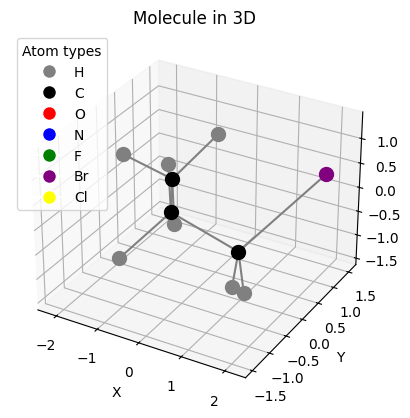

In [137]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np

def plot_molecule_3D(smiles):
    """
    Plot a molecule in 3D with different colors for different types of atoms and bonds between atoms.
    Args:
    - smiles (str): SMILES representation of the molecule.
    """
    # Generate RDKit molecule from SMILES
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print("Error: Unable to generate molecule from SMILES.")
        return
    
    # Add explicit hydrogens
    mol = Chem.AddHs(mol)

    # Generate 3D coordinates
    AllChem.EmbedMolecule(mol)
    AllChem.UFFOptimizeMolecule(mol)

    # Extract atom coordinates and symbols
    coords = mol.GetConformer().GetPositions()
    symbols = [atom.GetSymbol() for atom in mol.GetAtoms()]

    # Create 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Define colors for different atom types
    atom_colors = {'H': 'gray', 'C': 'black', 'O': 'red', 'N': 'blue', 'F': 'green', 'Br': 'purple', 'Cl': 'yellow'}

    # Plot atoms with different colors
    for atom_idx, symbol in enumerate(symbols):
        x, y, z = coords[atom_idx]
        color = atom_colors.get(symbol, 'brown')  # Default to brown for unknown atoms
        ax.scatter(x, y, z, c=color, label=symbol, s=100)

    # Helper function to plot bonds
    def plot_bond(ax, start_pos, end_pos, offset=np.array([0, 0, 0])):
        ax.plot([start_pos[0] + offset[0], end_pos[0] + offset[0]], 
                [start_pos[1] + offset[1], end_pos[1] + offset[1]], 
                [start_pos[2] + offset[2], end_pos[2] + offset[2]], c='gray')

    # Plot bonds between atoms with different styles for single and double bonds
    for bond in mol.GetBonds():
        start_idx = bond.GetBeginAtomIdx()
        end_idx = bond.GetEndAtomIdx()
        start_pos = coords[start_idx]
        end_pos = coords[end_idx]
        bond_type = bond.GetBondType()
        
        if bond_type == Chem.rdchem.BondType.SINGLE:
            plot_bond(ax, start_pos, end_pos)
        elif bond_type == Chem.rdchem.BondType.DOUBLE:
            # Calculate an offset direction perpendicular to the bond
            bond_vector = end_pos - start_pos
            normal_vector = np.cross(bond_vector, np.array([1, 0, 0]))
            if np.linalg.norm(normal_vector) < 1e-3:
                normal_vector = np.cross(bond_vector, np.array([0, 1, 0]))
            normal_vector /= np.linalg.norm(normal_vector)  # Normalize the vector
            offset = normal_vector * 0.0125  # Adjust the offset distance to make lines closer
            plot_bond(ax, start_pos, end_pos, offset)
            plot_bond(ax, start_pos, end_pos, -offset)

    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Molecule in 3D')

    # Show legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor=color, label=symbol)
               for symbol, color in atom_colors.items()]
    ax.legend(handles=handles, title='Atom types', loc='best')

    # Show plot
    plt.show()
    
plot_molecule_3D(string_input_mol)


In [138]:
# Function that returns the row of the elements formation reaction
def compare_molecule_with_data(element):
    return ''.join(element.split()).lower() == ''.join(string_input_mol.split()).lower()

# Initialize a variable to store the row number
found_row_number = None
rows=[]
# Iterate over the last three columns of the DataFrame
for column_name in valid_smiles_df.columns[-5:-1]:
    column = valid_smiles_df[column_name]
    # Check if any element in the column matches the input molecule
    for index, value in column.items():
        if compare_molecule_with_data(value):
            # Store the row number where the molecule is found
            found_row_number = index
            rows.append(found_row_number)
    else:
        continue  # Continue to the next column if molecule not found in current column

# Check if the molecule was found and return the row number
if found_row_number is not None:
   print(rows)
else:
    print("The product is not in the database")

The product is not in the database


In [139]:
"""
This code finds the isomers (if there is one) if the product searched isn't in the database.
"""

import itertools

def generate_permutations(input_string):
    # Generate all permutations of the input string
    permutations = itertools.permutations(input_string)
    # Convert each permutation tuple to a string and add to the list
    permutation_list = [''.join(p) for p in permutations]
    return permutation_list

all_isomers=generate_permutations(clean_string)
print (all_isomers)
valid_smiles_isomers=[]

for i in range(len(all_isomers)):
    if is_smiles(all_isomers[i]):
        valid_smiles_isomers.append(all_isomers[i])
    else:
        pass
valid_smiles_isomers=list(set(valid_smiles_isomers))
print (valid_smiles_isomers)

if found_row_number is None:
        choice=input("Your product isn't in the database do-you want to look for an isomer molecule? (enter yes/no) ")
        if choice == "no":
            print("Exiting.")
        else:
            
            # Initialize a variable to store the row number
            found_row_number = None
            rows=[]
            # Iterate over the last three columns of the DataFrame
            for column_name in Isomers_dataFrame.columns[0 : 6]:
                column = Isomers_dataFrame[column_name]
            # Check if any element in the column matches the input molecule
            for index, value in column.items():
                if compare_molecule_with_data(value):
                    # Store the row number where the molecule is found
                    found_row_number = index
                    rows.append(found_row_number)
                else:
                    continue  # Continue to the next column if molecule not found in current column

        # Check if the molecule was found and return the row number
        if found_row_number is not None:
           print(rows)
        else:
           print("The product is not in the database, please try with an other molecule")



TypeError: 'function' object is not iterable

In [140]:
import pandas as pd

def compare_molecule_with_data(element, string_input_mol,start_col=0, end_col=None):
    return ''.join(element.split()).lower() == ''.join(string_input_mol.split()).lower()

def find_molecule_rows(dataFrame, string_input_mol, start_col=0, end_col=None):
    """
    Search through the specified range of columns in a DataFrame for the input molecule.
    
    Args:
    - dataFrame (pd.DataFrame): The DataFrame to search.
    - string_input_mol (str): The molecule to search for.
    - start_col (int): The starting column index for the search.
    - end_col (int): The ending column index for the search. If None, searches until the last column.

    Returns:
    - List[int]: A list of row indices where the molecule is found.
    """
    # Initialize a list to store the row numbers
    rows = []
    
    # Set end_col to the last column index if not provided
    if end_col is None:
        end_col = dataFrame.shape[1]
    
    # Iterate over the specified range of columns in the DataFrame
    for column_name in dataFrame.columns[start_col:end_col]:
        column = dataFrame[column_name]
        # Check if any element in the column matches the input molecule
        for index, value in column.items():
            if compare_molecule_with_data(value, string_input_mol):
                # Store the row number where the molecule is found
                rows.append(index)
    
    return rows

if find_molecule_rows(valid_smiles_df, string_input_mol, start_col=0, end_col=None):
    print("Rows where the molecule is found:", rows)
else:
    print("The product is not in the database")


The product is not in the database


In [144]:
print(clean_string(string_input_mol))

BrCCC


In [ ]:
"""
This code finds the isomers (if there is ones) if the product searched isn't in the database.
"""

import itertools

def generate_permutations(input_string):
    # Generate all permutations of the input string
    permutations = itertools.permutations(input_string)
    # Convert each permutation tuple to a string and add to the list
    permutation_list = [''.join(p) for p in permutations]
    return permutation_list

all_isomers=generate_permutations(clean_string(string_input_mol))
print (all_isomers)
valid_smiles_isomers=[]

for i in range(len(all_isomers)):
    if is_smiles(all_isomers[i]):
        valid_smiles_isomers.append(all_isomers[i])
    else:
        pass
valid_smiles_isomers=list(set(valid_smiles_isomers))
print (valid_smiles_isomers)

print (string_input_mol)
rows = []

# Check if the molecule is not found in the valid_smiles_df
if find_molecule_rows(valid_smiles_df, string_input_mol, start_col=0, end_col=None) == []:
    choice = input("Your product isn't in the database. Do you want to look for an isomer molecule? (enter yes/no) ")
    if choice.lower() == "no":
        print("Exiting.")
    else:
        # Iterate over valid_smiles_isomers and append results to 'just'
        for i in range(len(valid_smiles_isomers)):
            result = find_molecule_rows(Isomers_dataFrame, valid_smiles_isomers[i], start_col=0, end_col=None)
            if result:  # Ensure that only non-empty results are appended
                rows.append(result)
                
        rows = [item for sublist in rows for item in sublist]        
        # Check if any rows were found in 'just' and print the results
        if rows:
            print(rows)
        else:
            print("The product is not in the database, please try with another molecule.")



[10:32:28] SMILES Parse Error: syntax error while parsing: BCrCC
[10:32:28] SMILES Parse Error: Failed parsing SMILES 'BCrCC' for input: 'BCrCC'
[10:32:28] SMILES Parse Error: syntax error while parsing: BCrCC
[10:32:28] SMILES Parse Error: Failed parsing SMILES 'BCrCC' for input: 'BCrCC'
[10:32:28] SMILES Parse Error: syntax error while parsing: BCCrC
[10:32:28] SMILES Parse Error: Failed parsing SMILES 'BCCrC' for input: 'BCCrC'
[10:32:28] SMILES Parse Error: syntax error while parsing: BCCCr
[10:32:28] SMILES Parse Error: Failed parsing SMILES 'BCCCr' for input: 'BCCCr'
[10:32:28] SMILES Parse Error: syntax error while parsing: BCCrC
[10:32:28] SMILES Parse Error: Failed parsing SMILES 'BCCrC' for input: 'BCCrC'
[10:32:28] SMILES Parse Error: syntax error while parsing: BCCCr
[10:32:28] SMILES Parse Error: Failed parsing SMILES 'BCCCr' for input: 'BCCCr'
[10:32:28] SMILES Parse Error: syntax error while parsing: BCrCC
[10:32:28] SMILES Parse Error: Failed parsing SMILES 'BCrCC' for 

['BrCCC', 'BrCCC', 'BrCCC', 'BrCCC', 'BrCCC', 'BrCCC', 'BCrCC', 'BCrCC', 'BCCrC', 'BCCCr', 'BCCrC', 'BCCCr', 'BCrCC', 'BCrCC', 'BCCrC', 'BCCCr', 'BCCrC', 'BCCCr', 'BCrCC', 'BCrCC', 'BCCrC', 'BCCCr', 'BCCrC', 'BCCCr', 'rBCCC', 'rBCCC', 'rBCCC', 'rBCCC', 'rBCCC', 'rBCCC', 'rCBCC', 'rCBCC', 'rCCBC', 'rCCCB', 'rCCBC', 'rCCCB', 'rCBCC', 'rCBCC', 'rCCBC', 'rCCCB', 'rCCBC', 'rCCCB', 'rCBCC', 'rCBCC', 'rCCBC', 'rCCCB', 'rCCBC', 'rCCCB', 'CBrCC', 'CBrCC', 'CBCrC', 'CBCCr', 'CBCrC', 'CBCCr', 'CrBCC', 'CrBCC', 'CrCBC', 'CrCCB', 'CrCBC', 'CrCCB', 'CCBrC', 'CCBCr', 'CCrBC', 'CCrCB', 'CCCBr', 'CCCrB', 'CCBrC', 'CCBCr', 'CCrBC', 'CCrCB', 'CCCBr', 'CCCrB', 'CBrCC', 'CBrCC', 'CBCrC', 'CBCCr', 'CBCrC', 'CBCCr', 'CrBCC', 'CrBCC', 'CrCBC', 'CrCCB', 'CrCBC', 'CrCCB', 'CCBrC', 'CCBCr', 'CCrBC', 'CCrCB', 'CCCBr', 'CCCrB', 'CCBrC', 'CCBCr', 'CCrBC', 'CCrCB', 'CCCBr', 'CCCrB', 'CBrCC', 'CBrCC', 'CBCrC', 'CBCCr', 'CBCrC', 'CBCCr', 'CrBCC', 'CrBCC', 'CrCBC', 'CrCCB', 'CrCBC', 'CrCCB', 'CCBrC', 'CCBCr', 'CCrBC', 

In [97]:
if Isomers_dataFrame["Product 1"].eq('BrCCC').any() or Isomers_dataFrame["Product 2"].eq('BrCCC').any():
    print("'BrCCC' exists in the DataFrame.")
else:
    print("'BrCCC' does not exist in the DataFrame.")


'BrCCC' exists in the DataFrame.


In [123]:
"""
This code prints the yield and shows the image of the reaction corresponding
"""
# Convert the 'Yield' column to float
split_dataFrame['yield'] = split_dataFrame['yield'].astype(float)

# Assuming 'rows_to_compare' is a list containing the row numbers to compare

# Subset the DataFrame to include only the specified rows
subset_df = split_dataFrame.iloc[rows]
print(subset_df)

# Find the index of the row with the highest yield
max_yield_row_index = subset_df['yield'].idxmax()

# Retrieve the row with the highest yield
max_yield_row = valid_smiles_df.loc[max_yield_row_index]

print("Row with the highest yield:")
print(max_yield_row)

# print the reaction
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem

# Create a reaction SMARTS string
reaction_smarts = split_dataFrame.iloc[max_yield_row_index, 6]
# Parse the reaction SMARTS string

reaction = AllChem.ReactionFromSmarts(reaction_smarts)

# Draw the reaction
reaction_image = Draw.ReactionToImage(reaction)

# Save or display the image
reaction_image.show()


  Reactant 1 Reactant 2 Product 1  Product 2 Product 3      yield  \
3      [Br-]  BrC(C)(C)     [Br-]  BrC(C)(C)            24.206642   
4      [Br-]    BrC(C)C     [Br-]    BrC(C)C            18.450753   

                    reaction_smarts  
3  [Br-].BrC(C)(C)>>[Br-].BrC(C)(C)  
4      [Br-].BrC(C)C>>[Br-].BrC(C)C  
Row with the highest yield:
Reactant 1                                    [Br-]
Reactant 2                                BrC(C)(C)
Product 1                                     [Br-]
Product 2                                 BrC(C)(C)
Product 3                                          
yield                             24.20664222186525
reaction_smarts    [Br-].BrC(C)(C)>>[Br-].BrC(C)(C)
Name: 3, dtype: object


In [96]:
! pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ---------------------------------------- 0.0/162.8 kB ? eta -:--:--
     -- ------------------------------------- 10.2/162.8 kB ? eta -:--:--
     ------ ------------------------------ 30.7/162.8 kB 445.2 kB/s eta 0:00:01
     ------------- ----------------------- 61.4/162.8 kB 550.5 kB/s eta 0:00:01
     ------------------------ ----------- 112.6/162.8 kB 656.4 kB/s eta 0:00:01
     ------------------------------- ---- 143.4/162.8 kB 655.8 kB/s eta 0:00:01
     ------------------------------- ---- 143.4/162.8 kB 655.8 kB/s eta 0:00:01
     ------------------------------- ---- 143.4/162.8 kB 655.8 kB/s eta 0:00:01
     ------------------------------------ 162.8/162.8 kB 465.0 kB/s eta 0:00:00
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
   ---------------------------------------- 0.0/7.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.7 MB 1.4 MB/s eta 0:00:06
   ---------------